In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

prng = np.random.RandomState(20240410)

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Science-Concepts/main/assignment3/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Science-Concepts/main/assignment3/data/test.csv')

In [3]:
# data table containing training data
train.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0,7


In [4]:
# data table containing testing data without y (needs submission for evaluation)
test.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,article_id
0,134,11,217,0.631579,1.0,0.818966,4,2,2,0,...,0.136364,0.5,-0.170370,-0.200000,-0.155556,0.288889,-0.155556,0.211111,0.155556,2
1,415,11,1041,0.489423,1.0,0.700321,22,3,0,14,...,0.050000,1.0,-0.426268,-1.000000,-0.100000,0.975000,0.300000,0.475000,0.300000,4
2,625,9,486,0.599585,1.0,0.727273,4,3,1,0,...,0.062500,0.7,-0.387821,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000,10
3,148,14,505,0.509018,1.0,0.718861,8,4,1,1,...,0.100000,1.0,-0.284722,-0.400000,-0.050000,0.000000,0.000000,0.500000,0.000000,13
4,294,14,274,0.620301,1.0,0.726190,5,1,1,0,...,0.100000,0.6,-0.333333,-0.333333,-0.333333,0.000000,0.000000,0.500000,0.000000,26


# Explonatary Data Analysis

In [5]:
# check for empty cells
train.columns[train.isnull().any()]

Index([], dtype='object')

We don't have missing values

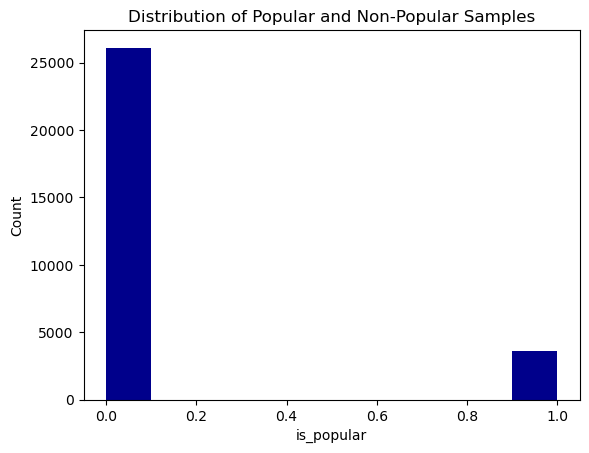

In [12]:
# Set ggplot style
#plt.style.use('ggplot')

train['is_popular'].hist(grid=False,color='darkblue')

# Adding labels and title

plt.title('Distribution of Popular and Non-Popular Samples')
plt.xlabel('is_popular')
plt.ylabel('Count')

# Show plot
plt.show()

# Benchmark Model
I will first create a Random Forest model to serve as my benchmark (no fine tuning, just a simple RF model). Based on my experiences, RF model performs the best, that's why i am choosing it.

In [7]:
y_train = train['is_popular']
x_train = train.drop(columns=['is_popular'])
x_test = test

In [8]:
# Benchmark simple Random Forest model
steps = [
    ("random_forest", RandomForestRegressor(random_state=prng))
]

pipe_rf = Pipeline(steps)

pipe_rf.fit(x_train, y_train)

Pipeline(steps=[('random_forest',
                 RandomForestRegressor(random_state=RandomState(MT19937) at 0x1FD9CA73B40))])

In [9]:
# calculate train auc
y_train_pred = pipe_rf.predict(x_train)
print(roc_auc_score(y_train, y_train_pred))

1.0


In [10]:
# create funtion that takes a pipeline model as an input and creates the submission file needed to evaluate it on the test set
def create_submission_file(model):
    # use the x_test to predict the probabilities
    y_predicted = model.predict(x_test)
    # create a submission file with the same format as the submission sample file
    test_submission = pd.DataFrame({'article_id': x_test['article_id'],
                                    'score': y_predicted})

    return test_submission.to_csv('test_submission.csv',index=False)

In [11]:
create_submission_file(pipe_rf) # this achieves an accuracy of 0.6773 on the y_test